In [0]:
!pip install wget
import wget
wget.download('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar')

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'images.tar'

In [0]:
!pip install -i https://test.pypi.org/simple/ supportlib
import supportlib.gettingdata as getdata

Looking in indexes: https://test.pypi.org/simple/


In [0]:
getdata.tarextract('/content/images.tar')

In [0]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F

In [0]:
!mkdir train
import shutil
import os
path = '/content/Images'
des = '/content/train'
from tqdm import tqdm
for i in tqdm(os.listdir('/content/Images')):
  path1 = os.path.join(path , i)
  for j in os.listdir(path1):
    path2 = os.path.join(path1,j)
    path3 = '{}_{}.jpg'.format(i,j)      
    des1 = os.path.join(des,path3)
    shutil.copyfile(path2 , des1)

100%|██████████| 120/120 [00:04<00:00, 25.81it/s]


In [0]:
nz = 100
ngf = 64
ndf = 64
nc = 3
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [0]:
gen = Generator().to('cuda')
from torchsummary import summary
summary(gen,(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [0]:
dis1 = Discriminator().to('cuda')
from torchsummary import summary
summary(dis1,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [0]:
adversarial_loss = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dis1.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
gen.apply(weights_init)
dis1.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [0]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0, 1)
    return image

In [0]:
!mkdir statedict

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


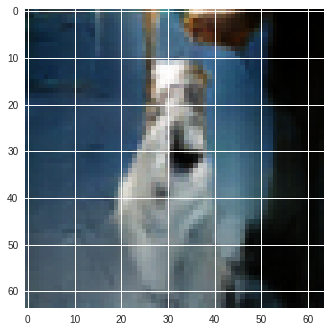

[Epoch 0/1000] [Batch 160/161] [D loss: 0.026716] [G loss: 4.380607]
[Epoch 1/1000] [Batch 160/161] [D loss: 0.025900] [G loss: 4.116822]
[Epoch 2/1000] [Batch 160/161] [D loss: 0.034370] [G loss: 3.912393]
[Epoch 3/1000] [Batch 160/161] [D loss: 0.015683] [G loss: 5.049681]
[Epoch 4/1000] [Batch 160/161] [D loss: 0.021926] [G loss: 4.683447]
[Epoch 5/1000] [Batch 160/161] [D loss: 0.735649] [G loss: 0.620586]
[Epoch 6/1000] [Batch 160/161] [D loss: 0.302658] [G loss: 2.683776]
[Epoch 7/1000] [Batch 160/161] [D loss: 0.087346] [G loss: 3.348211]
[Epoch 8/1000] [Batch 160/161] [D loss: 0.032436] [G loss: 4.475936]
[Epoch 9/1000] [Batch 160/161] [D loss: 0.037558] [G loss: 4.142423]


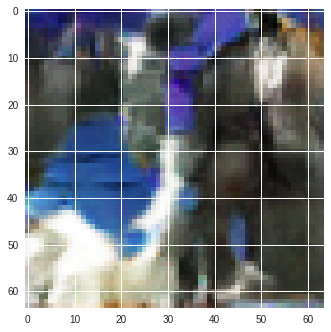

[Epoch 10/1000] [Batch 160/161] [D loss: 0.026326] [G loss: 4.754600]
[Epoch 11/1000] [Batch 160/161] [D loss: 0.030686] [G loss: 4.236873]
[Epoch 12/1000] [Batch 160/161] [D loss: 0.023449] [G loss: 4.601189]
[Epoch 13/1000] [Batch 160/161] [D loss: 0.025313] [G loss: 5.741615]
[Epoch 14/1000] [Batch 160/161] [D loss: 0.023603] [G loss: 6.761709]
[Epoch 15/1000] [Batch 160/161] [D loss: 0.021863] [G loss: 4.339974]
[Epoch 16/1000] [Batch 160/161] [D loss: 0.011436] [G loss: 5.316434]
[Epoch 17/1000] [Batch 160/161] [D loss: 0.979766] [G loss: 0.536712]
[Epoch 18/1000] [Batch 160/161] [D loss: 0.603729] [G loss: 0.847012]
[Epoch 19/1000] [Batch 160/161] [D loss: 0.820938] [G loss: 0.654158]


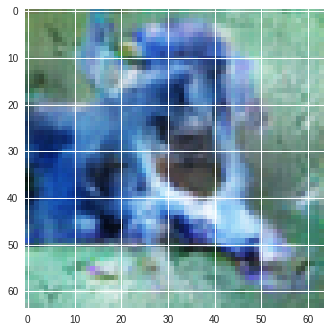

[Epoch 20/1000] [Batch 160/161] [D loss: 0.708122] [G loss: 4.362501]
[Epoch 21/1000] [Batch 160/161] [D loss: 0.041656] [G loss: 4.620680]
[Epoch 22/1000] [Batch 160/161] [D loss: 0.038523] [G loss: 3.909745]
[Epoch 23/1000] [Batch 160/161] [D loss: 0.023679] [G loss: 4.442639]
[Epoch 24/1000] [Batch 160/161] [D loss: 0.027387] [G loss: 4.477370]
[Epoch 25/1000] [Batch 160/161] [D loss: 0.027367] [G loss: 4.905930]
[Epoch 26/1000] [Batch 160/161] [D loss: 0.031342] [G loss: 5.690029]
[Epoch 27/1000] [Batch 160/161] [D loss: 0.011348] [G loss: 5.198452]
[Epoch 28/1000] [Batch 160/161] [D loss: 0.014278] [G loss: 4.945881]
[Epoch 29/1000] [Batch 160/161] [D loss: 0.020163] [G loss: 4.740856]


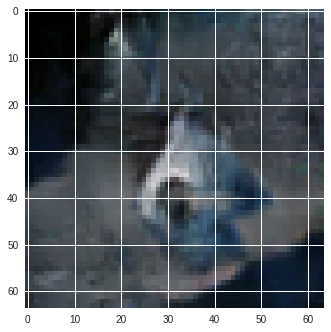

[Epoch 30/1000] [Batch 160/161] [D loss: 0.014433] [G loss: 4.838087]
[Epoch 31/1000] [Batch 160/161] [D loss: 0.630007] [G loss: 1.155709]
[Epoch 32/1000] [Batch 160/161] [D loss: 0.576306] [G loss: 1.233710]
[Epoch 33/1000] [Batch 160/161] [D loss: 0.128710] [G loss: 3.699274]
[Epoch 34/1000] [Batch 160/161] [D loss: 0.066731] [G loss: 3.374289]
[Epoch 35/1000] [Batch 160/161] [D loss: 0.034685] [G loss: 5.144217]
[Epoch 36/1000] [Batch 160/161] [D loss: 0.029887] [G loss: 4.174405]


KeyboardInterrupt: ignored

In [0]:
Tensor = torch.cuda.FloatTensor if 'cuda' else torch.FloatTensor
g_losses1 = []
d_losses1 = []
import matplotlib.pyplot as plt
for epoch in range(1000):
    for i, imgs in enumerate(dataloader):

        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        
        real_imgs = Variable(imgs.type(Tensor))
        optimizer_G.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],100,1,1))))
        gen_imgs = gen(z)
        b = dis1(gen_imgs)
        g_loss = adversarial_loss(b, valid)
        g_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(dis1(real_imgs), valid)
        fake_loss = adversarial_loss(dis1(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
      
        d_loss.backward()
        optimizer_D.step()
        g_losses1.append(g_loss.item())
        d_losses1.append(d_loss.item())
    if(epoch%10==0):
      a = im_convert(gen_imgs)
      plt.imshow(a)
      plt.show()

    path = '/content/statedict' + '{}'.format(epoch)
    torch.save(gen.state_dict(), path)
    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, 1000, i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))

In [0]:
z = Variable(Tensor(np.random.normal(0, 1, (20,100,1,1))))
gen_imgs = gen(z)
a = []
for i in range(20):
  b = im_convert(gen_imgs[i])
  a.append(b)

In [0]:
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7, 7), nrows=5, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img, cmap='Greys_r')
    plt.show()

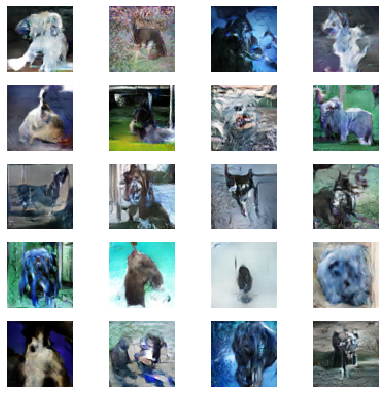

In [0]:
view_samples(a)

In [0]:
def error_plot(dis_loss, gen_loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(gen_loss,label="G")
    plt.plot(dis_loss,label="D")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

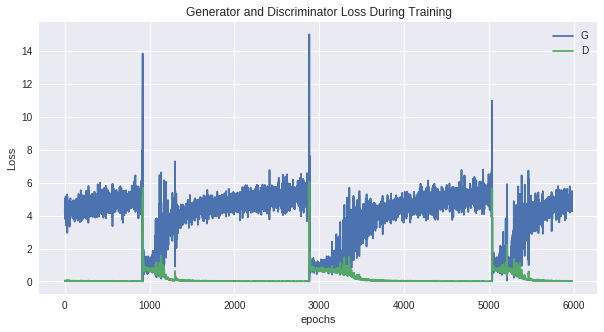

In [0]:
error_plot(d_losses1,g_losses1)

In [0]:
from matplotlib.pyplot import imshow,show

In [0]:
from torch.utils.data import Dataset, DataLoader
class gender_dataset(Dataset):
  def __init__(self,image_dir,transform = None):
    
    self.img_dir = image_dir
    self.transform = transform
    self.id = os.listdir(self.img_dir)
  def __len__(self):
    return len(os.listdir(self.img_dir))
  def __getitem__(self,idx):
    img_name = os.path.join(self.img_dir, self.id[idx])
    image = cv2.imread(img_name)
    
    if self.transform:
      image = self.transform(image)
    return image

In [0]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((64,64)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

In [0]:
gender_data = gender_dataset('/content/train',transform)

In [0]:
dataloader = DataLoader(gender_data, batch_size=128)